issues to resolve

1- fix the under development, there is an issue with the reserves (done)

2- fix the producing, some countries go above 20 (DONE)

3- fix the issue related to gap between full supply model and demand (DONE)

3- incorporate cost models (DONE)

4- calculate investment (DONE)

5- Calculate cost curves

6- create dashboard

In [1]:
import pandas as pd


raw_df = pd.read_excel("/Users/mycomputer/Desktop/supply/raw_updated_ytf.xlsx")

demand_df = pd.read_excel("/Users/mycomputer/Desktop/supply/demand.xlsx")

ud_df =  pd.read_excel("/Users/mycomputer/Desktop/supply/ud_updated.xlsx")

inflation_df =  pd.read_excel("/Users/mycomputer/Desktop/supply/inflation.xlsx")

final_cost_df = pd.read_excel("/Users/mycomputer/Desktop/supply/combined_cost.xlsx")

In [2]:
TRL = 20
CCOST = 35000
DIST = 0.5

TRL = TARGET RESERVES LIFE
CCOST = CAPACITY COST
DIST = DISTRIBUTION, USED TO DISTRIBUTE THE CAPACITY COST AND FIND COST OVER SPECIFIC NUMBER OF YEARS 

In [3]:
C_1_growth_rates = {
    2024: 1.06,
    2025: 1.06,
    2026: 1.05,
    2027: 1.04,
    2028: 1.00,
    2029: 0.96,
    2030: 0.98,
    2031: 1.00,
    2032: 0.95
}

I put these rates because the country C_1 has clear plan of its supply in the next few years. 

In [4]:
# Use only rows with asset_type = "producing" for the year TRL23
raw_df_producing = raw_df[raw_df['asset_type'] == "producing"]

# Initialize the forecasted production dataframe with the production values of TRL23 for each country
forecasted_production_df = raw_df_producing[['country', 'production']].copy()
forecasted_production_df.columns = ['country', '2023']
forecasted_production_df = forecasted_production_df.set_index('country')

# Initialize the reserves dataframe to keep track of remaining reserves for each year
forecasted_reserves_df = raw_df_producing[['country', 'reserves']].copy()
forecasted_reserves_df.columns = ['country', '2023']
forecasted_reserves_df = forecasted_reserves_df.set_index('country')

# Dictionary to hold the last recorded reserves life for each country
last_recorded_reserves_life = raw_df_producing.set_index('country')['reserves_life'].to_dict()



In [5]:
for year in range(2024, 2051):
    forecasted_production_df[str(year)] = None
    forecasted_reserves_df[str(year)] = None
    
    for country in raw_df_producing['country']:
        # Get the production and reserves for the country from the previous year.
        production_prev_year = forecasted_production_df.at[country, str(year - 1)]
        reserves_prev_year = forecasted_reserves_df.at[country, str(year - 1)]

        # Calculate reserves life based on the previous year's data.
        reserves_life_prev_year = reserves_prev_year / production_prev_year if production_prev_year > 0 else float('inf')  # avoid division by zero

        if country == "C_1":
            if year in C_1_growth_rates:
                # Adjust the production based on the predefined growth rate.
                forecasted_production_df.at[country, str(year)] = production_prev_year * C_1_growth_rates[year]
            else:
                # If no specific growth rate is defined, you might keep the production stable or apply a default rule.
                forecasted_production_df.at[country, str(year)] = production_prev_year  # or apply a default rule
        else:
            # General rule for other fields.
            if reserves_life_prev_year > TRL:
                forecasted_production_df.at[country, str(year)] = production_prev_year * 1.2  # Increase by 10%
            else:
                # If the last recorded reserves life for the country was below TRL, maintain that reserves life.
                if last_recorded_reserves_life[country] < TRL:
                    new_production = reserves_prev_year / last_recorded_reserves_life[country]
                    forecasted_production_df.at[country, str(year)] = min(new_production, reserves_prev_year)  # Ensure reserves don't go negative
                else:
                    # Gently adjust the production.
                    target_reserves_life = min(TRL, last_recorded_reserves_life[country] + 1)  # Aim for a gradual increase.
                    new_production = reserves_prev_year / target_reserves_life
                    forecasted_production_df.at[country, str(year)] = min(new_production, reserves_prev_year)  # Ensure reserves don't go negative.

        # Update reserves for the current year based on the new production values.
        forecasted_reserves_df.at[country, str(year)] = reserves_prev_year - forecasted_production_df.at[country, str(year)]

        # Update the last recorded reserves life for countries.
        new_reserves_life = reserves_prev_year / forecasted_production_df.at[country, str(year)] if forecasted_production_df.at[country, str(year)] > 0 else float('inf')  # avoid division by zero
        last_recorded_reserves_life[country] = new_reserves_life

# Print or export your data after the loop, as needed.


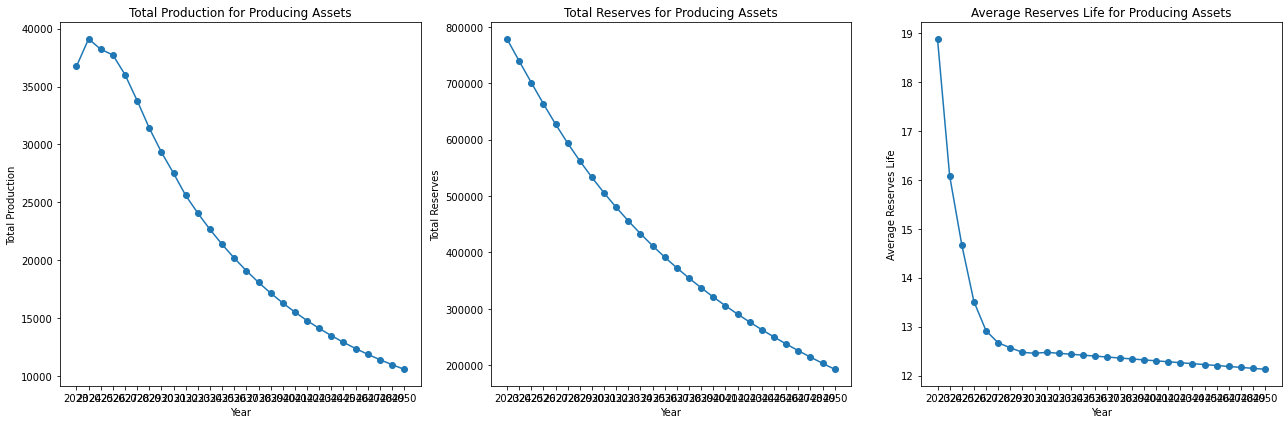

In [6]:
import matplotlib.pyplot as plt

# Convert the dataframes to long format for easier merging
production_long = forecasted_production_df.reset_index().melt(id_vars=['country'], var_name='year', value_name='production')
reserves_long = forecasted_reserves_df.reset_index().melt(id_vars=['country'], var_name='year', value_name='reserves')

# Merge the two DataFrames on 'year' and 'country'
forecasted_producing_df = pd.merge(production_long, reserves_long, on=['year', 'country'])

# Calculate reserves_life for each row
forecasted_producing_df['reserves_life'] = forecasted_producing_df.apply(
    lambda row: row['reserves'] / row['production'] if row['production'] != 0 else 0, axis=1
)

# Group data by year and sum up the production and reserves, and average the reserves life
grouped_producing_df = forecasted_producing_df.groupby('year').agg({
    'production': 'sum',
    'reserves': 'sum',
    'reserves_life': 'mean'  # taking the average of reserves life
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Plot for Total Production
plt.subplot(1, 3, 1)
plt.plot(grouped_producing_df['year'], grouped_producing_df['production'], marker='o', linestyle='-')
plt.title('Total Production for Producing Assets')
plt.xlabel('Year')
plt.ylabel('Total Production')

# Plot for Total Reserves
plt.subplot(1, 3, 2)
plt.plot(grouped_producing_df['year'], grouped_producing_df['reserves'], marker='o', linestyle='-')
plt.title('Total Reserves for Producing Assets')
plt.xlabel('Year')
plt.ylabel('Total Reserves')

# Plot for Average Reserves Life
plt.subplot(1, 3, 3)
plt.plot(grouped_producing_df['year'], grouped_producing_df['reserves_life'], marker='o', linestyle='-')
plt.title('Average Reserves Life for Producing Assets')
plt.xlabel('Year')
plt.ylabel('Average Reserves Life')

plt.tight_layout()
plt.show()


In [7]:
# Create a dictionary to store reserves for each country in TRL23 for 'ud' assets
reserves_TRL23 = raw_df[(raw_df['asset_type'] == 'ud') & (raw_df['year'] == 2023)].set_index('country')['reserves'].to_dict()

# Initialize an empty DataFrame to store the forecasted results for UD
forecasted_ud_df = pd.DataFrame(columns=['year', 'country', 'production', 'reserves', 'reserves_life'])

# Loop through each unique country in ud_df
for country in ud_df['country'].unique():
    # Filter data specific to the current country
    country_data = ud_df[ud_df['country'] == country].sort_values(by='year')

    # Initialize variables for current production
    current_production = 0

    # Get reserves for the current country from the reserves_TRL23 dictionary
    current_reserves = reserves_TRL23.get(country, 0)

    # Loop through each year from TRL24 to TRL50
    for year in range(2024, 2051):
        # If there's a project completing this year, add its production to the current production
        if year in country_data['year'].values:
            yearly_projects = country_data[country_data['year'] == year]
            current_production += yearly_projects['production'].sum()

        # Calculate reserves life for the current year
        reserves_life = current_reserves / current_production if current_production > 0 else float('inf')

        # If reserves life is less than TRL, adjust the production
        if reserves_life < TRL:
            current_production = current_reserves / TRL

        # Update reserves based on production
        current_reserves -= current_production

        # Append the results to the forecasted_ud_df
        forecasted_ud_df = forecasted_ud_df.append({
            'year': year,
            'country': country,
            'production': current_production,
            'reserves': current_reserves,
            'reserves_life': reserves_life
        }, ignore_index=True)

# Calculate the difference between demand and the supply from producing assets

# 1. Sum the production for each year from the producing assets
total_supply_from_producing = forecasted_production_df.sum()

# 2. Subtract the total production from the total demand d each year
demand_supply_difference = demand_df.set_index('year')['demand'] - total_supply_from_producing

# Convert the forecasted UD dataframe into a pivot table format for easier calculations
forecasted_ud_production_df_pivot = forecasted_ud_df.pivot(index='country', columns='year', values='production')

# Calculate the total supply (producing + UD) for each year
total_supply_per_year = total_supply_from_producing + forecasted_ud_production_df_pivot.sum()

# Calculate the excess supply for each year
excess_supply_per_year = total_supply_per_year - demand_df.set_index('year')['demand']

# Identify and adjust the UD production for years with excess supply
for year, excess in excess_supply_per_year.items():
    if excess > 0:
        # Calculate the proportional reduction required
        reduction_percentage = excess / forecasted_ud_production_df_pivot[year].sum()

        # Apply the reduction to the UD production for that year
        forecasted_ud_production_df_pivot[year] = forecasted_ud_production_df_pivot[year] * (1 - reduction_percentage)


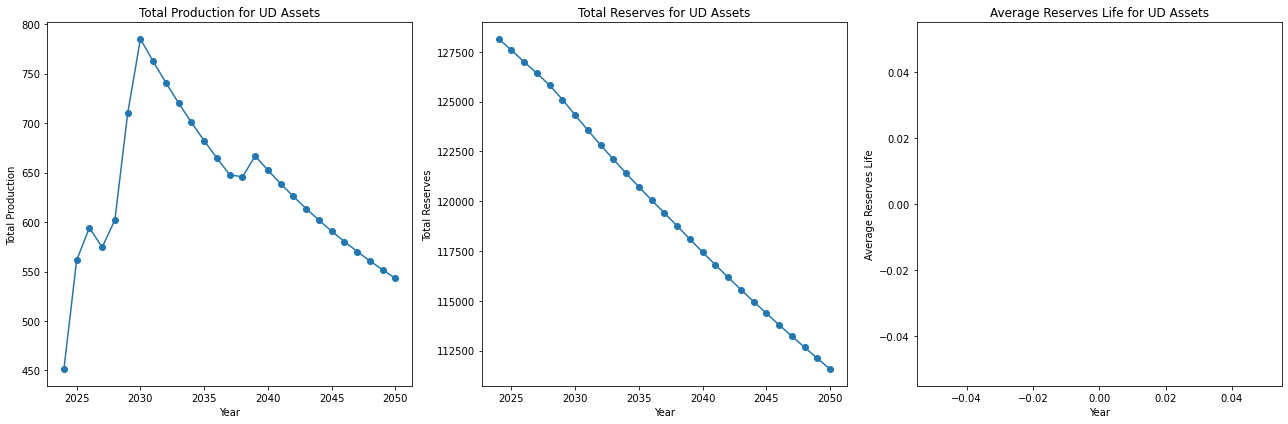

In [8]:
import matplotlib.pyplot as plt

# Assuming forecasted_ud_df is your DataFrame for UD assets
# and it has columns ['year', 'country', 'production', 'reserves', 'reserves_life']

# Group data by year and sum up the production and reserves, and average the reserves life
grouped_ud_df = forecasted_ud_df.groupby('year').agg({
    'production': 'sum',
    'reserves': 'sum',
    'reserves_life': 'mean'  # taking the average of reserves life
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Plot for Total Production
plt.subplot(1, 3, 1)
plt.plot(grouped_ud_df['year'], grouped_ud_df['production'], marker='o', linestyle='-')
plt.title('Total Production for UD Assets')
plt.xlabel('Year')
plt.ylabel('Total Production')

# Plot for Total Reserves
plt.subplot(1, 3, 2)
plt.plot(grouped_ud_df['year'], grouped_ud_df['reserves'], marker='o', linestyle='-')
plt.title('Total Reserves for UD Assets')
plt.xlabel('Year')
plt.ylabel('Total Reserves')

# Plot for Average Reserves Life
plt.subplot(1, 3, 3)
plt.plot(grouped_ud_df['year'], grouped_ud_df['reserves_life'], marker='o', linestyle='-')
plt.title('Average Reserves Life for UD Assets')
plt.xlabel('Year')
plt.ylabel('Average Reserves Life')

plt.tight_layout()
plt.show()


In [9]:

# PLOT
import plotly.graph_objects as go

# Convert year columns of both DataFrames to string
forecasted_production_df.columns = forecasted_production_df.columns.astype(str)
forecasted_ud_production_df_pivot.columns = forecasted_ud_production_df_pivot.columns.astype(str)

# Proceed with the plotting code you have:

common_years = list(set(forecasted_production_df.columns) & set(forecasted_ud_production_df_pivot.columns))
common_years.sort()

total_production = forecasted_production_df[common_years].sum()
total_ud_production = forecasted_ud_production_df_pivot[common_years].sum()

total_production.fillna(0, inplace=True)
total_ud_production.fillna(0, inplace=True)

total_production_array = total_production.to_numpy(dtype='float64')
total_ud_production_array = total_ud_production.to_numpy(dtype='float64')

# Create the figure
fig = go.Figure()

# Add traces for 'Producing' and 'Under Development'
fig.add_trace(go.Scatter(x=common_years, y=total_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Producing',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_ud_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Under Development',
                    stackgroup='one'))

# Customize the layout
fig.update_layout(
    title="Total Production for All Years (Producing + Under Development)",
    xaxis_title="Year",
    yaxis_title="Total Production",
    hovermode="x unified"  # Enable hover
)

# Show the figure
fig.show()



In [10]:
# Make sure 'year' column is of integer type
demand_df['year'] = demand_df['year'].astype(int)

# Loop through each year
for year in range(2024, 2051):
    # Fetch the demand for that year
    try:
        demand = demand_df.loc[demand_df['year'] == year, 'demand'].iloc[0]
    except IndexError:
        print(f"No demand data found for year {year}")
        continue
    # Your code for calculating deficit goes here


In [11]:
# Convert the forecasted UD dataframe into a pivot table format for easier calculations
forecasted_ud_production_df_pivot = forecasted_ud_df.pivot(index='country', columns='year', values='production')

# Initialize a DataFrame to store the deficit for each year
deficit_df = pd.DataFrame(columns=['year', 'deficit'])

# Loop through each year
for year in range(2024, 2051):
    year_str = str(year)

    # Fetch the demand for that year
    try:
        demand = demand_df.loc[demand_df['year'] == year, 'demand'].iloc[0]
    except IndexError:
        print(f"No demand data found for year {year}")
        continue

    # Fetch the total production (from 'producing' assets) for that year
    total_production = forecasted_production_df[year_str].sum()

    # Fetch the total production (from 'under development' assets) for that year
    total_ud_production = forecasted_ud_production_df_pivot[year].sum()

    # Calculate the total supply
    total_supply = total_production + total_ud_production

    # Calculate the deficit
    deficit = demand - total_supply

    # Store the deficit for this year in the DataFrame
    deficit_df = deficit_df.append({'year': year, 'deficit': deficit}, ignore_index=True)

print(deficit_df)


      year       deficit
0   2024.0  -1626.315134
1   2025.0    -49.675871
2   2026.0    834.058717
3   2027.0   2987.188117
4   2028.0   5628.458608
5   2029.0   8322.360694
6   2030.0  10760.888115
7   2031.0  12782.119284
8   2032.0  14890.831786
9   2033.0  16616.972419
10  2034.0  18215.815896
11  2035.0  19699.058867
12  2036.0  20975.026116
13  2037.0  22155.395214
14  2038.0  23234.995730
15  2039.0  24212.814384
16  2040.0  25154.373019
17  2041.0  26000.613290
18  2042.0  26786.414663
19  2043.0  27516.916472
20  2044.0  28196.773265
21  2045.0  28830.204178
22  2046.0  28939.237013
23  2047.0  29009.147602
24  2048.0  29043.094985
25  2049.0  29043.952860
26  2050.0  29014.337723


In [12]:
# Iterate through the years in your deficit dataframe.
for index, row in deficit_df.iterrows():
    year = int(row['year'])  # Ensure the year is an integer for indexing.
    surplus_value = row['deficit']  # The surplus situation, indicated by a negative deficit.

    # Check if there's a surplus, i.e., the deficit is negative.
    if surplus_value < 0:
        # The surplus is the absolute value of the negative deficit.
        surplus_reduction = abs(surplus_value)

        # Retrieve the current production level for "C_30".
        current_production = forecasted_production_df.at["C_30", str(year)]

        # Make sure we don't reduce more than what's available. Avoid setting production to a negative value.
        new_production = max(current_production - surplus_reduction, 0)

        # Update the forecasted production dataframe with the new production level.
        forecasted_production_df.at["C_30", str(year)] = new_production

        # This part is optional and depends on whether you're tracking changes in reserves.
        current_reserves = forecasted_reserves_df.at["C_30", str(year)]  # if you have such a dataframe
        new_reserves = current_reserves + surplus_reduction  # since we're reducing production, reserves should increase
        forecasted_reserves_df.at["C_30", str(year)] = new_reserves  # if you have such a dataframe


for the code above, i am trying to trim supply from producing asset, i chose one country, but can i distribute the trim on all the countries except C_1?

In [13]:
import pandas as pd

# Initialize a DataFrame to store the forecasted production, reserves, and reserves life for 'Discovered' assets
forecasted_discovered_df = pd.DataFrame(columns=['year', 'country', 'production', 'reserves', 'reserves_life'])

# Filter raw_df to only include 'Discovered' assets for the year TRL23
discovered_df = raw_df[(raw_df['asset_type'] == 'discovered') & (raw_df['year'] == 2023)]

# This is a placeholder; replace it with the actual value.

# Loop through each year from TRL24 to TRL50
for year in range(2024, 2051):
    # Fetch the deficit for that year from 'deficit_df'
    try:
        deficit = deficit_df.loc[deficit_df['year'] == year, 'deficit'].values[0]
    except IndexError:
        print(f"No deficit data found for year {year}")
        deficit = 0  # Defaulting to zero in case of missing data

    total_discovered_reserves = discovered_df['reserves'].sum()

    # If there's a deficit, we proceed with calculations, otherwise, we set production and other metrics to zero.
    if deficit > 0 and total_discovered_reserves > 0:
        for country in discovered_df['country'].unique():
            # Fetch the initial reserves for that country
            initial_reserves = discovered_df.loc[discovered_df['country'] == country, 'reserves'].values[0]

            # Calculate the production based on the proportion of total reserves and the deficit
            production = (initial_reserves / total_discovered_reserves) * deficit

            # Update reserves and calculate reserves life
            reserves = initial_reserves - production
            reserves_life = reserves / production if production > 0 else float('inf')

            # If reserves life falls below TRL, adjust the production
            if reserves_life < TRL:
                production = reserves / TRL
                reserves_life = TRL  # set reserves_life to TRL
                reserves = initial_reserves - production  # update reserves after adjusting production

            # Store the forecasted data for this year and country in the DataFrame
            forecasted_discovered_df = forecasted_discovered_df.append({
                'year': year,
                'country': country,
                'production': production,
                'reserves': reserves,
                'reserves_life': reserves_life
            }, ignore_index=True)

            # Update the reserves in 'discovered_df' for the next iteration
            discovered_df.loc[discovered_df['country'] == country, 'reserves'] = reserves
    else:
        # For years with no deficit or no reserves, we set the production and related metrics to zero
        for country in discovered_df['country'].unique():
            forecasted_discovered_df = forecasted_discovered_df.append({
                'year': year,
                'country': country,
                'production': 0,  # No production
                'reserves': discovered_df.loc[discovered_df['country'] == country, 'reserves'].values[0],  # Unchanged reserves
                'reserves_life': float('inf')  # Infinite reserves life as there's no production
            }, ignore_index=True)

# Display the forecasted DataFrame
print(forecasted_discovered_df)


/Users/mycomputer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      year country  production      reserves  reserves_life
0     2024     C_1           0      0.100000            inf
1     2024     C_2           0      0.000000            inf
2     2024     C_3           0   8344.200000            inf
3     2024     C_4           0  12293.200000            inf
4     2024     C_5           0   6247.800000            inf
...    ...     ...         ...           ...            ...
1399  2050    C_48    5.653388    164.894950           20.0
1400  2050    C_49   56.100135   1636.298209           20.0
1401  2050    C_50    0.400382     11.678113           20.0
1402  2050    C_51    4.278745    124.800097           20.0
1403  2050    C_52  643.044877  18755.983066           20.0

[1404 rows x 5 columns]


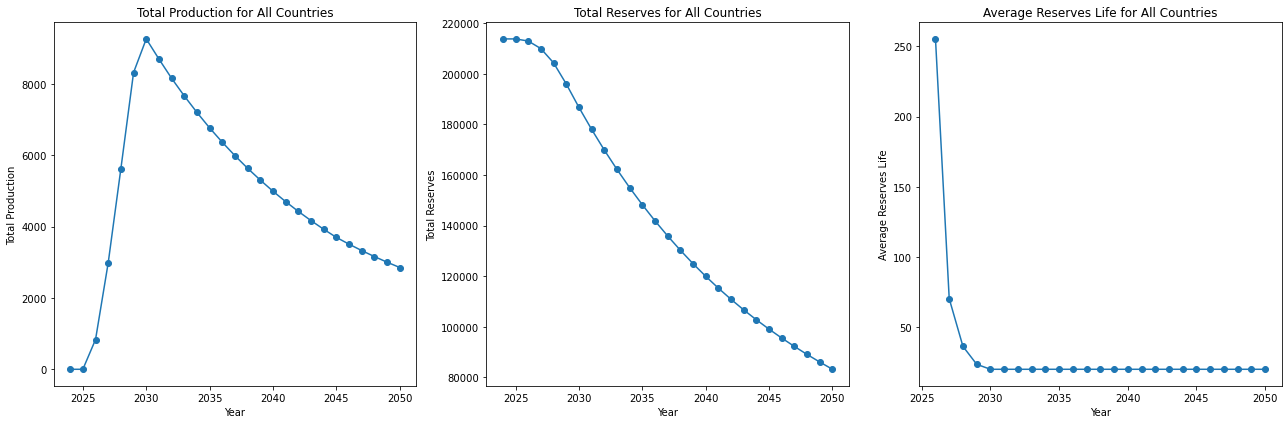

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Replace 'inf' with 'NaN'
forecasted_discovered_df['reserves_life'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Group data by year and sum up the production and reserves, also mean for reserves_life
grouped_df = forecasted_discovered_df.groupby('year').agg({
    'production': 'sum',
    'reserves': 'sum',
    'reserves_life': 'mean'  # use mean or any other aggregation function that makes sense in your case
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Plot Total Production
plt.subplot(1, 3, 1)
plt.plot(grouped_df['year'], grouped_df['production'], marker='o', linestyle='-')
plt.title('Total Production for All Countries')
plt.xlabel('Year')
plt.ylabel('Total Production')

# Plot Total Reserves
plt.subplot(1, 3, 2)
plt.plot(grouped_df['year'], grouped_df['reserves'], marker='o', linestyle='-')
plt.title('Total Reserves for All Countries')
plt.xlabel('Year')
plt.ylabel('Total Reserves')

# Plot Average Reserves Life
plt.subplot(1, 3, 3)
plt.plot(grouped_df['year'], grouped_df['reserves_life'], marker='o', linestyle='-')
plt.title('Average Reserves Life for All Countries')
plt.xlabel('Year')
plt.ylabel('Average Reserves Life')

plt.tight_layout()
plt.show()


In [15]:
import plotly.graph_objects as go

# Pivot the forecasted_ud_df DataFrame for easier calculations
forecasted_ud_production_df = forecasted_ud_df.pivot(index='country', columns='year', values='production')

# Determine the common years across the dataframes
common_years = list(set(forecasted_production_df.columns) & set(forecasted_ud_production_df.columns) & set(forecasted_discovered_df['year'].astype(str).unique()))

# Ensure all years from TRL24 to TRL50 are in common_years
all_years = [str(year) for year in range(2024, 2051)]
for year in all_years:
    if year not in common_years:
        common_years.append(year)

common_years.sort()

# Standardize year columns to string type
forecasted_production_df.columns = forecasted_production_df.columns.astype(str)
forecasted_ud_production_df.columns = forecasted_ud_production_df.columns.astype(str)

# Ensure all countries in forecasted_production_df are in forecasted_ud_production_df
for country in forecasted_production_df.index:
    if country not in forecasted_ud_production_df.index:
        forecasted_ud_production_df.loc[country] = [0] * len(common_years)

# Ensure all countries in forecasted_ud_production_df are in forecasted_production_df
for country in forecasted_ud_production_df.index:
    if country not in forecasted_production_df.index:
        forecasted_production_df.loc[country] = [0] * len(common_years)

# Ensure forecasted_discovered_df has all years
for year in common_years:
    if int(year) not in forecasted_discovered_df['year'].values:
        new_data = {'year': int(year), 'country': 'Unknown', 'production': 0, 'reserves': 0, 'reserves_life': 0}
        forecasted_discovered_df = forecasted_discovered_df.append(new_data, ignore_index=True)

# Calculate the total production for each asset type and year
total_production = forecasted_production_df[common_years].sum()
total_ud_production = forecasted_ud_production_df[common_years].sum()
total_discovered_production = forecasted_discovered_df.groupby('year')['production'].sum()

# Handle NaNs
total_production.fillna(0, inplace=True)
total_ud_production.fillna(0, inplace=True)
total_discovered_production.fillna(0, inplace=True)

# Convert to NumPy arrays of type float64
total_production_array = total_production.to_numpy(dtype='float64')
total_ud_production_array = total_ud_production.to_numpy(dtype='float64')
total_discovered_production_array = total_discovered_production.to_numpy(dtype='float64')

# Create the figure
fig = go.Figure()

# Add traces for 'Producing', 'Under Development', and 'Discovered'
fig.add_trace(go.Scatter(x=common_years, y=total_production_array, hoverinfo='x+y', mode='lines', name='Producing', stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_ud_production_array, hoverinfo='x+y', mode='lines', name='Under Development', stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_discovered_production_array, hoverinfo='x+y', mode='lines', name='Discovered', stackgroup='one'))

# Customize the layout
fig.update_layout(
    title="Total Production for All Years (Producing + Under Development + Discovered)",
    xaxis_title="Year",
    yaxis_title="Total Production",
    hovermode="x unified"
)

# Show the figure
fig.show()


In [16]:
import pandas as pd

# Initialize a DataFrame to store the forecasted production, reserves, and reserves life for 'YTF' assets
forecasted_ytf_df = pd.DataFrame(columns=['year', 'country', 'production', 'reserves', 'reserves_life'])

# Filter raw_df to only include 'YTF' assets for the year TRL23
ytf_df = raw_df[(raw_df['asset_type'] == 'ytf') & (raw_df['year'] == 2023)]

# Loop through each year from TRL24 to TRL50
for year in range(2024, 2051):
    # Fetch the initial deficit for that year from 'deficit_df'
    try:
        initial_deficit = deficit_df.loc[deficit_df['year'] == year, 'deficit'].values[0]
    except IndexError:
        print(f"No initial deficit data found for year {year}")
        continue

    # Adjust the deficit to account for the production from discovered assets in forecasted_discovered_df
    discovered_production_for_year = forecasted_discovered_df.loc[forecasted_discovered_df['year'] == year, 'production'].sum()
    deficit = initial_deficit - discovered_production_for_year

    if deficit > 0:
        total_ytf_reserves = ytf_df['reserves'].sum()  # Calculate the total YTF reserves for that year
    else:
        deficit = 0  # No deficit means no need for additional production
        total_ytf_reserves = 0  # Set the reserves to zero, as they won't be needed

    # Loop through each country
    for country in ytf_df['country'].unique():
        # Fetch the initial reserves for that country
        initial_reserves = ytf_df.loc[ytf_df['country'] == country, 'reserves'].values[0]

        if deficit > 0:
            # Calculate the production for that country based on its proportion of total reserves and the deficit
            production = (initial_reserves / total_ytf_reserves) * deficit

            # Update reserves and calculate reserves life
            reserves = initial_reserves - production
            reserves_life = reserves / production if production > 0 else float('inf')

            # If reserves life falls below TRL, adjust the production
            if reserves_life < TRL:
                production = reserves / TRL
                reserves_life = TRL  # set reserves_life to TRL
                reserves = initial_reserves - production  # update reserves after adjusting production
        else:
            production = 0
            reserves = initial_reserves  # Reserves remain unchanged
            reserves_life = float('inf')  # Infinite reserves life as no production

        # Store the forecasted data for this year and country in the DataFrame
        forecasted_ytf_df = forecasted_ytf_df.append({
            'year': year,
            'country': country,
            'production': production,
            'reserves': reserves,
            'reserves_life': reserves_life
        }, ignore_index=True)

        # Update the reserves in 'ytf_df' for the next iteration
        ytf_df.loc[ytf_df['country'] == country, 'reserves'] = reserves

# Display the forecasted DataFrame
print(forecasted_ytf_df)


/Users/mycomputer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



      year country   production       reserves  reserves_life
0     2024     C_1            0       0.100000            inf
1     2024     C_2            0   24218.850000            inf
2     2024     C_3            0   60917.330000            inf
3     2024     C_4            0   20461.130000            inf
4     2024     C_5            0   24908.070000            inf
...    ...     ...          ...            ...            ...
1399  2050    C_48    82.129758    2220.901728      27.041377
1400  2050    C_49  1178.728911   31874.452699      27.041377
1401  2050    C_50    14.609884     395.071392      27.041377
1402  2050    C_51   136.631769    3694.711151      27.041377
1403  2050    C_52  6016.768593  162701.706931      27.041377

[1404 rows x 5 columns]


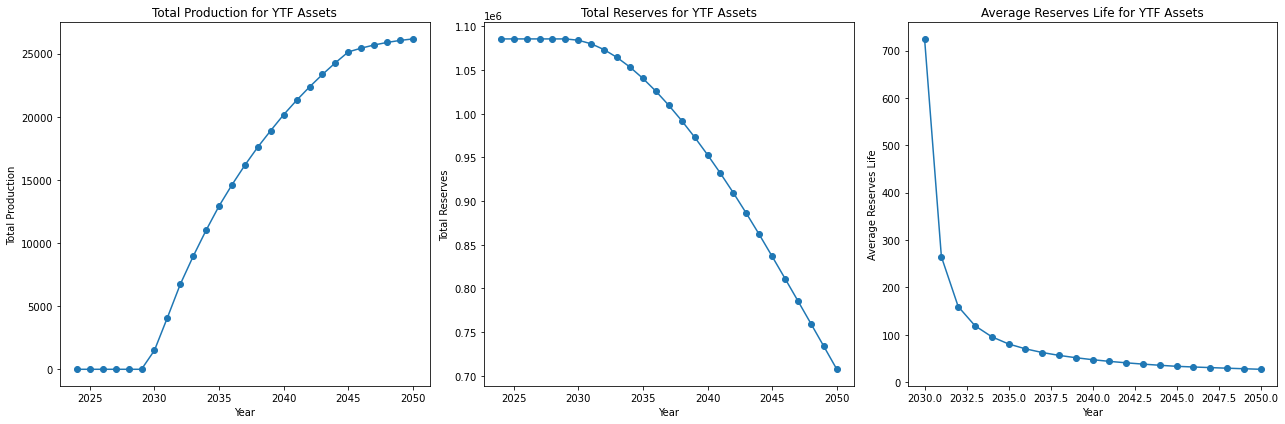

In [17]:
import matplotlib.pyplot as plt

# Assuming forecasted_ytf_df is your DataFrame
# and it has columns ['year', 'country', 'production', 'reserves', 'reserves_life']

# Group data by year and sum up the production, reserves, and average the reserves life
grouped_ytf_df = forecasted_ytf_df.groupby('year').agg({
    'production': 'sum',
    'reserves': 'sum',
    'reserves_life': 'mean'  # taking the average of reserves life
}).reset_index()

# Plotting
plt.figure(figsize=(18, 6))

# Plot for Total Production
plt.subplot(1, 3, 1)
plt.plot(grouped_ytf_df['year'], grouped_ytf_df['production'], marker='o', linestyle='-')
plt.title('Total Production for YTF Assets')
plt.xlabel('Year')
plt.ylabel('Total Production')

# Plot for Total Reserves
plt.subplot(1, 3, 2)
plt.plot(grouped_ytf_df['year'], grouped_ytf_df['reserves'], marker='o', linestyle='-')
plt.title('Total Reserves for YTF Assets')
plt.xlabel('Year')
plt.ylabel('Total Reserves')

# Plot for Average Reserves Life
plt.subplot(1, 3, 3)
plt.plot(grouped_ytf_df['year'], grouped_ytf_df['reserves_life'], marker='o', linestyle='-')
plt.title('Average Reserves Life for YTF Assets')
plt.xlabel('Year')
plt.ylabel('Average Reserves Life')

plt.tight_layout()
plt.show()


In [18]:
import plotly.graph_objects as go

# Assuming forecasted_production_df, forecasted_ud_production_df, forecasted_discovered_df, and forecasted_ytf_df are your dataframes

# Step 1: Ensure all DataFrames have the same columns (years)
common_years = list(set(forecasted_production_df.columns) & set(forecasted_ud_production_df.columns) & set(forecasted_discovered_df['year'].astype(str).unique()) & set(forecasted_ytf_df['year'].astype(str).unique()))
common_years.sort()

# Step 2: Sum up the production for each year across all countries for all types of assets
total_production = forecasted_production_df[common_years].sum()
total_ud_production = forecasted_ud_production_df[common_years].sum()
total_discovered_production = forecasted_discovered_df.groupby('year')['production'].sum()
total_ytf_production = forecasted_ytf_df.groupby('year')['production'].sum()

# Step 3: Handle NaNs if any
total_production.fillna(0, inplace=True)
total_ud_production.fillna(0, inplace=True)
total_discovered_production.fillna(0, inplace=True)
total_ytf_production.fillna(0, inplace=True)

# Step 4: Convert demand 'year' column to string and filter to common_years
demand_df['year'] = demand_df['year'].astype(str)
demand_data = demand_df.loc[demand_df['year'].isin(common_years), 'demand']

# Step 5: Convert to NumPy arrays of type float64
total_production_array = total_production.to_numpy(dtype='float64')
total_ud_production_array = total_ud_production.to_numpy(dtype='float64')
total_discovered_production_array = total_discovered_production.to_numpy(dtype='float64')
total_ytf_production_array = total_ytf_production.to_numpy(dtype='float64')

# Create the figure
fig = go.Figure()

# Add traces for 'Producing', 'Under Development', 'Discovered', 'YTF', and 'Demand'
fig.add_trace(go.Scatter(x=common_years, y=total_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Producing',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_ud_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Under Development',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_discovered_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Discovered',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=total_ytf_production_array,
                    hoverinfo='x+y',
                    mode='lines',
                    name='YTF',
                    stackgroup='one'))
fig.add_trace(go.Scatter(x=common_years, y=demand_data,
                    hoverinfo='x+y',
                    mode='lines',
                    name='Demand',
                    line=dict(width=3, dash='dash')))

# Customize the layout
fig.update_layout(
    title="Total Production for All Years (Producing + Under Development + Discovered + YTF)",
    xaxis_title="Year",
    yaxis_title="Total Production",
    hovermode="x unified"  # Enable hover
)

# Show the figure
fig.show()


In [19]:
import pandas as pd

# Create DataFrame with data
export_data = pd.DataFrame({
    'Year': common_years,
    'Producing': total_production_array,
    'Under Development': total_ud_production_array,
    'Discovered': total_discovered_production_array,
    'YTF': total_ytf_production_array,
    'Demand': demand_data.to_numpy(dtype='float64')  # assuming demand_data is a Series
})

# Export DataFrame to CSV
export_data.to_csv('stacked_data_export.csv', index=False)


In [20]:
# Ensure all DataFrames have the same columns (years)
common_years = list(set(forecasted_production_df.columns) & set(forecasted_ud_production_df.columns) & set(forecasted_discovered_df['year'].astype(str).unique()) & set(forecasted_ytf_df['year'].astype(str).unique()))
common_years.sort()

# Create an empty dataframe to store combined production data
combined_production_df = pd.DataFrame(columns=['country', 'year', 'producing', 'under_development', 'discovered', 'ytf'])

# Iterate through each country and year to populate the dataframe
countries = forecasted_production_df.index
for country in countries:
    for year in common_years:
        producing_value = forecasted_production_df.loc[country, str(year)]
        ud_value = forecasted_ud_production_df.loc[country, str(year)]
        discovered_value = forecasted_discovered_df.loc[forecasted_discovered_df['country'] == country].set_index('year').loc[int(year), 'production']
        ytf_value = forecasted_ytf_df.loc[forecasted_ytf_df['country'] == country].set_index('year').loc[int(year), 'production']

        combined_production_df = combined_production_df.append({
            'country': country,
            'year': year,
            'producing': producing_value,
            'under_development': ud_value,
            'discovered': discovered_value,
            'ytf': ytf_value
        }, ignore_index=True)

# Display the dataframe for examination
print(combined_production_df)


     country  year    producing under_development  discovered          ytf
0        C_1  2024  4449.350000                 0           0            0
1        C_1  2025  4716.311000                 0           0            0
2        C_1  2026  4952.126550                 0     0.00039            0
3        C_1  2027  5150.211612                 0    0.001397            0
4        C_1  2028  5150.211612                 0    0.002632            0
...      ...   ...          ...               ...         ...          ...
1399    C_52  2046   980.953729                 0  790.344976   5849.15539
1400    C_52  2047   892.697520                 0   750.04004  5906.371206
1401    C_52  2048   812.381704                 0   712.15555  5952.845337
1402    C_52  2049   739.291886                 0  676.538107  5989.395281
1403    C_52  2050   672.777944                 0  643.044877  6016.768593

[1404 rows x 6 columns]


In [21]:
print(forecasted_production_df.head())
print(forecasted_ud_production_df.head())
print(forecasted_discovered_df.head())
print(forecasted_ytf_df.head())


             2023      2024       2025        2026         2027         2028  \
country                                                                        
C_1      4197.500   4449.35   4716.311  4952.12655  5150.211612  5150.211612   
C_2       955.935  1147.122  1376.5464  1651.85568  1559.924616  1473.109811   
C_3      1625.345  1950.414  2340.4968  2808.59616   2659.35137  2518.037234   
C_4       311.710   374.052   448.8624   538.63488   646.361856   612.478763   
C_5       609.550    731.46    877.752   1053.3024   995.246584   940.390683   

                2029         2030         2031         2032  ...         2041  \
country                                                      ...                
C_1      4944.203148  4845.319085  4845.319085   4603.05313  ...   4603.05313   
C_2      1391.126528  1313.705878  1240.593935  1171.550906  ...   699.752983   
C_3       2384.23233  2257.537628  2137.575301  2023.987601  ...  1238.185383   
C_4       580.371863   549.948047 

In [22]:
combined_production_long = combined_production_df.melt(id_vars=['country', 'year'],
                                                      value_vars=['producing', 'under_development', 'discovered', 'ytf'],
                                                      var_name='asset_type',
                                                      value_name='production_value')


In [23]:
# Convert columns to appropriate data types
combined_production_long['year'] = combined_production_long['year'].astype(int)
combined_production_long['production_value'] = combined_production_long['production_value'].astype(float)

# Re-check the data types to confirm changes
print("Updated data types in combined_production_long:")
print(combined_production_long.dtypes)


Updated data types in combined_production_long:
country              object
year                  int64
asset_type           object
production_value    float64
dtype: object


In [24]:
# Extract unique countries
countries = combined_production_long['country'].unique()

# Desired asset types
asset_types = ['discovered', 'ytf']

# Create the base DataFrame structure
df_list = []

# Iterate through each country and asset type
for country in countries:
    for asset in asset_types:
        subset = combined_production_long[(combined_production_long['country'] == country) & 
                                          (combined_production_long['asset_type'] == asset) & 
                                          (combined_production_long['year'].between(2024, 2050))]

        # Check if subset is not empty
        if not subset.empty:
            for year in range(2024, 2051):
                prod_value = subset[subset['year'] == year]['production_value'].values[0] if year in subset['year'].values else None
                df_list.append({
                    'country': country,
                    'year': year,
                    'asset_type': asset,
                    'production': prod_value,
                    'capex': None  # Placeholder for CapEx, will fill later
                })

capex_df = pd.DataFrame(df_list)


# Convert production values to daily rate
capex_df['production'] = capex_df['production'] / 365

# Display the updated DataFrame
capex_df

# Initialize the 'capex' column to 0
capex_df['capex'] = 0.0

for country in capex_df['country'].unique():
    for asset in capex_df['asset_type'].unique():
        # Filter for the specific country and asset type
        country_asset_df = capex_df[(capex_df['country'] == country) & (capex_df['asset_type'] == asset)]
        
        # Find the index of the row with the maximum production for this country and asset
        max_prod_idx = country_asset_df['production'].idxmax()
        
        # Fill the 'capex' column for this row with the computed value
        capex_df.at[max_prod_idx, 'capex'] = country_asset_df.at[max_prod_idx, 'production'] * CCOST


# Divide the 'capex' column by 1000
capex_df['capex'] = capex_df['capex'] / 1000

# Display the updated DataFrame
capex_df

,country,year,asset_type,production,capex
0,C_1,2024,discovered,0.000000,0.000000
1,C_1,2025,discovered,0.000000,0.000000
2,C_1,2026,discovered,0.000001,0.000000
3,C_1,2027,discovered,0.000004,0.000000
4,C_1,2028,discovered,0.000007,0.000000
...,...,...,...,...,...
2803,C_52,2046,ytf,16.025083,0.000000
2804,C_52,2047,ytf,16.181839,0.000000
2805,C_52,2048,ytf,16.309165,0.000000
2806,C_52,2049,ytf,16.409302,0.000000


In [25]:
aggregated_capex_by_year = capex_df.groupby('year')['capex'].sum().reset_index()
aggregated_capex_by_year


,year,capex
0,2024,0.00000
1,2025,0.00000
2,2026,0.00000
3,2027,0.00000
4,2028,0.00000
5,2029,0.00000
6,2030,888.36063
7,2031,0.00000
8,2032,0.00000
9,2033,0.00000


In [26]:
import numpy as np

# 1. For each country and asset type, get the sum of capex.
country_asset_capex = capex_df.groupby(['country', 'asset_type'])['capex'].sum().reset_index()

# 2. & 3. Distribute this capex over the years 2024 to 2050 using a curve that gives a gradual increase at the beginning and smoothens out at the end. 
years = np.arange(2023, 2051)
power_curve = np.power(years - years.min(), DIST)  # Adjusting the power to 1.5 for a smoother tail-off
power_curve_normalized = power_curve / power_curve.sum()

for idx, row in country_asset_capex.iterrows():
    country, asset, capex_total = row['country'], row['asset_type'], row['capex']
    
    for year, weight in zip(years, power_curve_normalized):
        capex_df.loc[(capex_df['country'] == country) & (capex_df['asset_type'] == asset) & (capex_df['year'] == year), 'capex'] = weight * capex_total

# Display the updated DataFrame
capex_df.head(30)

# Summing up the capex for each year for each country
yearly_country_capex_df = capex_df.groupby(['country', 'year'])['capex'].sum().reset_index()

yearly_country_capex_df.head()

AAA = yearly_country_capex_df.groupby('year').sum().reset_index()
print(AAA)

    year       capex
0   2024   35.410790
1   2025   50.078419
2   2026   61.333287
3   2027   70.821579
4   2028   79.180933
5   2029   86.738366
6   2030   93.688143
7   2031  100.156838
8   2032  106.232369
9   2033  111.978749
10  2034  117.444303
11  2035  122.666573
12  2036  127.675418
13  2037  132.495042
14  2038  137.145398
15  2039  141.643158
16  2040  146.002426
17  2041  150.235257
18  2042  154.352053
19  2043  158.361865
20  2044  162.272624
21  2045  166.091325
22  2046  169.824181
23  2047  173.476732
24  2048  177.053948
25  2049  180.560307
26  2050  183.999860


In [27]:
# Convert final_cost to a long format
final_cost_long = pd.melt(final_cost_df, id_vars=['country', 'category'], var_name='year', value_name='cost')
final_cost_long['year'] = final_cost_long['year'].astype(int)  # Convert year to integer type

# Separate out dev_cost and find_cost
dev_cost_df = final_cost_long[final_cost_long['category'] == 'dev_cost'].drop(columns=['category'])
find_cost_df = final_cost_long[final_cost_long['category'] == 'find_cost'].drop(columns=['category'])

In [28]:
# Calculate dev_investment
dev_investment = combined_production_long.groupby(['country', 'year']).agg({'production_value': 'sum'}).reset_index()
dev_investment = pd.merge(dev_investment, dev_cost_df, on=['country', 'year'], how='left')
dev_investment['dev_cost'] = dev_investment['production_value'] * dev_investment['cost']
dev_investment = dev_investment[['country', 'year', 'dev_cost']]

# Calculate find_investment for ytf asset type only
ytf_production = combined_production_long[combined_production_long['asset_type'] == 'ytf']
ytf_production = ytf_production.groupby(['country', 'year']).agg({'production_value': 'sum'}).reset_index()
ytf_production = pd.merge(ytf_production, find_cost_df, on=['country', 'year'], how='left')
ytf_production['find_cost'] = ytf_production['production_value'] * ytf_production['cost']
ytf_production = ytf_production[['country', 'year', 'find_cost']]


In [29]:
# Calculate dev_investment
dev_investment = combined_production_long.groupby(['country', 'year']).agg({'production_value': 'sum'}).reset_index()
dev_investment = pd.merge(dev_investment, dev_cost_df, on=['country', 'year'], how='left')
dev_investment['dev_cost'] = (dev_investment['production_value'] * dev_investment['cost']) / 1000
dev_investment = dev_investment[['country', 'year', 'dev_cost']]

# Calculate find_investment for ytf asset type only
find_investment = combined_production_long[combined_production_long['asset_type'] == 'ytf']
find_investment = find_investment.groupby(['country', 'year']).agg({'production_value': 'sum'}).reset_index()
find_investment = pd.merge(find_investment, find_cost_df, on=['country', 'year'], how='left')
find_investment['find_cost'] = (find_investment['production_value'] * find_investment['cost']) / 1000
find_investment = find_investment[['country', 'year', 'find_cost']]


In [30]:
# Merging dev_investment, find_investment, and yearly_country_capex_df
country_final_investment_df = pd.merge(dev_investment, find_investment, on=['country', 'year'], how='outer')
country_final_investment_df = pd.merge(country_final_investment_df, yearly_country_capex_df[['country', 'year', 'capex']], on=['country', 'year'], how='outer')

# Fill NaN values with 0
country_final_investment_df = country_final_investment_df.fillna(0)

# Calculate the total column
country_final_investment_df['total'] = country_final_investment_df['capex'] + country_final_investment_df['dev_cost'] + country_final_investment_df['find_cost']

# Reorder columns
country_final_investment_df = country_final_investment_df[['country', 'year', 'capex', 'dev_cost', 'find_cost', 'total']]


In [31]:
# Calculate the cumulative inflation
inflation_df['cumulative_inflation'] = (1 + inflation_df['inflation']).cumprod()

# Rename 'total' column to 'nominal_investment' in country_final_investment_df
country_final_investment_df.rename(columns={'total': 'nominal_investment'}, inplace=True)

# Merge with inflation_df to get the 'cumulative_inflation' column

country_final_investment_df.head()

,country,year,capex,dev_cost,find_cost,nominal_investment
0,C_1,2024,0.000007,21.303488,0.0,21.303495
1,C_1,2025,0.000010,22.388328,0.0,22.388338
2,C_1,2026,0.000012,23.304709,0.0,23.304721
3,C_1,2027,0.000013,24.025744,0.0,24.025757
4,C_1,2028,0.000015,23.814591,0.0,23.814606


In [32]:
import numpy as np
import pandas as pd

# I'm assuming you've already read your data into country_final_investment_df
# country_final_investment_df = pd.read_csv('your_data.csv')

# Parameters for the distribution curve
# Creating the distribution curve for the years
years = np.arange(2023, 2051)
power_curve = np.power(years - years.min(), DIST)  # Creating a power curve
power_curve_normalized = power_curve / power_curve.sum()  # Normalizing the curve

# Collecting unique countries from the DataFrame
unique_countries = country_final_investment_df['country'].unique()

# Initialize the DataFrame column if not existing
if 'distributed_find_cost' not in country_final_investment_df:
    country_final_investment_df['distributed_find_cost'] = 0

# Iterating through each unique country
for country in unique_countries:
    # Extract total find_cost for each country over all the years
    total_find_cost = country_final_investment_df[country_final_investment_df['country'] == country]['find_cost'].sum()

    # We distribute the 'find_cost' for each country across the specified years
    for year, weight in zip(years, power_curve_normalized):
        distributed_cost = weight * total_find_cost

        # Update the 'find_cost' directly in the DataFrame
        country_final_investment_df.loc[
            (country_final_investment_df['country'] == country) & (country_final_investment_df['year'] == year), 
            'find_cost'
        ] = distributed_cost

# Now, the 'find_cost' within each entry has been updated to reflect the distributed values across the years.

# Display the head of the DataFrame to verify the operation
print(country_final_investment_df.head())


  country  year     capex   dev_cost  find_cost  nominal_investment  \
0     C_1  2024  0.000007  21.303488        0.0           21.303495   
1     C_1  2025  0.000010  22.388328        0.0           22.388338   
2     C_1  2026  0.000012  23.304709        0.0           23.304721   
3     C_1  2027  0.000013  24.025744        0.0           24.025757   
4     C_1  2028  0.000015  23.814591        0.0           23.814606   

   distributed_find_cost  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  


In [33]:
country_final_investment_df = pd.merge(country_final_investment_df, inflation_df[['year', 'cumulative_inflation']], on='year', how='left')

# Calculate the 'real_investment' column
country_final_investment_df['real_investment'] = country_final_investment_df['nominal_investment'] / country_final_investment_df['cumulative_inflation']

# Drop the 'cumulative_inflation' column as it's no longer needed
country_final_investment_df.drop(columns=['cumulative_inflation'], inplace=True)

# Display the updated DataFrame
country_final_investment_df.head()

,country,year,capex,dev_cost,find_cost,nominal_investment,distributed_find_cost,real_investment
0,C_1,2024,0.000007,21.303488,0.0,21.303495,0,21.303495
1,C_1,2025,0.000010,22.388328,0.0,22.388338,0,21.949351
2,C_1,2026,0.000012,23.304709,0.0,23.304721,0,22.399770
3,C_1,2027,0.000013,24.025744,0.0,24.025757,0,22.640008
4,C_1,2028,0.000015,23.814591,0.0,23.814606,0,22.001015


In [34]:
import plotly.graph_objects as go

# Group by year and summing up the investments for all countries
grouped_df = country_final_investment_df.groupby('year').sum().reset_index()

# Calculate the cumulative investment until 2045 for both nominal and real investments
cumulative_nominal_2045 = grouped_df['nominal_investment'][grouped_df['year'] <= 2045].sum()
cumulative_real_2045 = grouped_df['real_investment'][grouped_df['year'] <= 2045].sum()

# Plot Nominal Investment
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=grouped_df['year'],
                      y=grouped_df['nominal_investment'],
                      name='Yearly Nominal Investment'))
fig1.add_annotation(text=f"Cumulative until 2045: {cumulative_nominal_2045:.2f}",
                    x=2045,
                    y=grouped_df['nominal_investment'].max() / 2,
                    showarrow=False)
fig1.update_layout(title='Nominal Investment (2024-2050)',
                   xaxis_title='Year',
                   yaxis_title='Investment',
                   xaxis=dict(tickvals=list(range(2024, 2051))))
fig1.show()

# Plot Real Investment
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=grouped_df['year'],
                      y=grouped_df['real_investment'],
                      name='Yearly Real Investment'))
fig2.add_annotation(text=f"Cumulative until 2045: {cumulative_real_2045:.2f}",
                    x=2045,
                    y=grouped_df['real_investment'].max() / 2,
                    showarrow=False)
fig2.update_layout(title='Real Investment (2024-2050)',
                   xaxis_title='Year',
                   yaxis_title='Investment (Adjusted for Inflation)',
                   xaxis=dict(tickvals=list(range(2024, 2051))))
fig2.show()


In [35]:
# 1. Add asset column
forecasted_producing_df['asset_type'] = 'producing'
forecasted_ud_df['asset_type'] = 'under_development'
forecasted_discovered_df['asset_type'] = 'discovered'
forecasted_ytf_df['asset_type'] = 'ytf'

# 2. Concatenate dataframes
combined_df = pd.concat([forecasted_producing_df, forecasted_ud_df, forecasted_discovered_df, forecasted_ytf_df])

# 3. Reshape the dataframe
# Keep only the necessary columns
combined_df = combined_df[['country', 'year', 'asset_type', 'production', 'reserves']]

# Convert production and reserves to float, in case they aren't already
combined_df['production'] = combined_df['production'].astype(float)
combined_df['reserves'] = combined_df['reserves'].astype(float)

# Calculate Reserves Life (RL) and handle potential division by zero (will result in inf values)
combined_df['reserves_life'] = combined_df['reserves'] / combined_df['production']
combined_df['reserves_life'].replace([np.inf, -np.inf], 0, inplace=True)

print(combined_df.head())


  country  year asset_type  production  reserves  reserves_life
0     C_1  2023  producing    4197.500  221254.1      52.710923
1     C_2  2023  producing     955.935   32204.9      33.689424
2     C_3  2023  producing    1625.345   57145.1      35.158751
3     C_4  2023  producing     311.710   13691.7      43.924481
4     C_5  2023  producing     609.550   20719.2      33.990977


In [36]:
# Group by year and asset_type
grouped_totals = combined_df.groupby(['year', 'asset_type']).agg({
    'production': 'sum',
    'reserves': 'sum'
}).reset_index()

# Calculate reserves life for the aggregated values
grouped_totals['reserves_life'] = grouped_totals['reserves'] / grouped_totals['production']
grouped_totals['reserves_life'].replace([np.inf, -np.inf], 0, inplace=True)

# Add a 'country' column with value 'Total'
grouped_totals['country'] = 'Total'

# Append the grouped totals to the original dataframe
combined_df = pd.concat([combined_df, grouped_totals], ignore_index=True)

print(combined_df.tail(len(grouped_totals)))


     country  year         asset_type    production      reserves  \
4777   Total  2024         discovered      0.000000  2.138196e+05   
4778   Total  2024  under_development    451.199472  1.281506e+05   
4779   Total  2024                ytf      0.000000  1.085686e+06   
4780   Total  2025         discovered      0.000000  2.138196e+05   
4781   Total  2025  under_development    561.448026  1.275892e+05   
...      ...   ...                ...           ...           ...   
4881   Total  2046          producing  12382.568990  2.376151e+05   
4882   Total  2047          producing  11884.668459  2.257304e+05   
4883   Total  2048          producing  11422.230633  2.143082e+05   
4884   Total  2049          producing  10992.406835  2.033158e+05   
4885   Total  2050          producing  10592.604347  1.927232e+05   

      reserves_life  
4777       0.000000  
4778     284.022053  
4779       0.000000  
4780       0.000000  
4781     227.250158  
...             ...  
4881      19.1894

In [37]:
# 1. Rename columns
rename_dict = {
    'capex': 'capacity cost',
    'dev_cost': 'development cost',
    'find_cost': 'exploration'
}
country_final_investment_df = country_final_investment_df.rename(columns=rename_dict)

# 2. Calculate real values with cumulative inflation
# First, calculate cumulative inflation
inflation_df['cumulative_inflation'] = (1 + inflation_df['inflation']).cumprod()

# Merge the cumulative inflation to the main dataframe
country_final_investment_df = country_final_investment_df.merge(inflation_df[['year', 'cumulative_inflation']], on='year', how='left')

# Calculate the real values
for col in ['capacity cost', 'development cost', 'exploration']:
    country_final_investment_df[col + '_real'] = country_final_investment_df[col] / country_final_investment_df['cumulative_inflation']

# 3. Create the 'total' column
columns_to_sum = ['capacity cost_real', 'development cost_real', 'exploration_real']
country_final_investment_df['total'] = country_final_investment_df[columns_to_sum].sum(axis=1)

# Keep only the desired columns
final_columns = ['country', 'year', 'capacity cost_real', 'development cost_real', 'exploration_real', 'total']
country_final_investment_df = country_final_investment_df[final_columns]

print(country_final_investment_df.head())


  country  year  capacity cost_real  development cost_real  exploration_real  \
0     C_1  2024            0.000007              21.303488               0.0   
1     C_1  2025            0.000009              21.949341               0.0   
2     C_1  2026            0.000011              22.399759               0.0   
3     C_1  2027            0.000013              22.639995               0.0   
4     C_1  2028            0.000014              22.001001               0.0   

       total  
0  21.303495  
1  21.949351  
2  22.399770  
3  22.640008  
4  22.001015  


In [38]:
# 1. Group by year and compute the sum
yearly_totals = country_final_investment_df.groupby('year').sum().reset_index()

# 2. Set country to 'Total' for these rows
yearly_totals['country'] = 'Total'

# 3. Append the yearly totals to the original dataframe
country_final_investment_df = pd.concat([country_final_investment_df, yearly_totals], sort=False).sort_values(by=['year', 'country']).reset_index(drop=True)

print(country_final_investment_df.tail())


     country  year  capacity cost_real  development cost_real  \
1426     C_6  2050            3.769438               4.612486   
1427     C_7  2050            0.043714               0.051845   
1428     C_8  2050            0.265200               0.400809   
1429     C_9  2050            0.541040               0.595878   
1430   Total  2050          109.954505             276.944233   

      exploration_real       total  
1426          0.000000    8.381925  
1427          0.000000    0.095558  
1428          0.000000    0.666008  
1429          0.000000    1.136918  
1430          0.382479  387.281216  


In [39]:
combined_df['year'] = combined_df['year'].astype(int)
demand_df['year'] = demand_df['year'].astype(int)
country_final_investment_df['year'] = country_final_investment_df['year'].astype(int)

In [40]:
# --- Start of Data Preparation ---
# Assuming you've loaded your data into respective DataFrames
# combined_df, demand_df, country_final_investment_df

# Divide the production by 365
combined_df['production'] /= 365

# Divide the demand by 365
demand_df['demand'] /= 365

# Rename the columns as needed
country_final_investment_df.rename(columns={'capex': 'capacity cost', 
                                            'dev_cost': 'development cost', 
                                            'find_cost': 'exploration'}, inplace=True)

# Sorting years for the cumulative calculation
country_final_investment_df.sort_values(by='year', inplace=True)

In [41]:
import pandas as pd
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go


# --- End of Data Preparation ---

app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Dashboard for Supply and Required Upstream Investment", style={'textAlign': 'center', 'color': 'white'}),

    dcc.Dropdown(
        id='country-selector',
        options=[{'label': country, 'value': country} for country in combined_df['country'].unique()],
        value='Total',
        clearable=False
    ),

    dcc.Graph(id='supply-graph'),
    dcc.Graph(id='costs-graph'),
    
    html.H3("Cumulative Investments", style={'textAlign': 'center', 'color': 'white'}),
    dash_table.DataTable(
        id='cumulative-investments-table',
        columns=[{"name": i, "id": i} for i in ['year', 'cumulative_investment']],
        style_header={'backgroundColor': 'rgb(30, 30, 30)'},
        style_cell={'backgroundColor': 'rgb(50, 50, 50)', 'color': 'white'}
    )
])

@app.callback(
    [Output('supply-graph', 'figure'),
     Output('costs-graph', 'figure'),
     Output('cumulative-investments-table', 'data')],
    [Input('country-selector', 'value')]
)
def update_graphs(selected_country):
    filtered_df = combined_df[combined_df['country'] == selected_country]
    
    # Supply graph...
    supply_fig = px.area(filtered_df, x='year', y='production', color='asset_type',
                         title='Liquid Hydrocarbon Supply by Asset Type', labels={'production': 'Supply'},
                         category_orders={"asset_type": ["producing", "under_development", "discovered", "ytf"]})
    supply_fig.update_layout(yaxis_title="Million Barrel per Day")
    supply_fig.update_xaxes(range=[2024, filtered_df['year'].max()])  # Setting the initial date to 2024
    if selected_country == "Total":
        supply_fig.add_traces(go.Scatter(x=demand_df['year'], y=demand_df['demand'], 
                                         mode='lines+markers', name='Demand', line=dict(dash='dash')))
    
    # Costs graph...
    costs_df = country_final_investment_df[country_final_investment_df['country'] == selected_country]
    costs_fig = px.bar(costs_df, x='year', y=['development cost_real', 'capacity cost_real', 'exploration_real'],
                       title='Required Upstream Investment')
    costs_fig.update_layout(yaxis_title="Real 2023 Billion USD")
    costs_fig.update_xaxes(range=[2024, costs_df['year'].max()])  # Setting the initial date to 2024

    # Getting cumulative investments for the selected country
    costs_df['total_cost'] = costs_df[['development cost_real', 'capacity cost_real', 'exploration_real']].sum(axis=1)
    costs_df['cumulative_investment'] = costs_df['total_cost'].cumsum()
    cumulative_investments = costs_df[costs_df['year'].isin([2030, 2035, 2040, 2045, 2050])]
    data = cumulative_investments[['year', 'cumulative_investment']].to_dict('records')

    return supply_fig, costs_fig, data

if __name__ == '__main__':
    app.run_server(debug=True, port=8050)  # change to an open port



The supply curve in the dashboard is different form the one in code [18], why is this? 

In [42]:
output_directory = "/Users/mycomputer/Desktop/supply/03- Output/"

combined_df.to_csv(output_directory + "combined_data.csv", index=False)
demand_df.to_csv(output_directory + "demand_data.csv", index=False)
country_final_investment_df.to_csv(output_directory + "investment_data.csv", index=False)


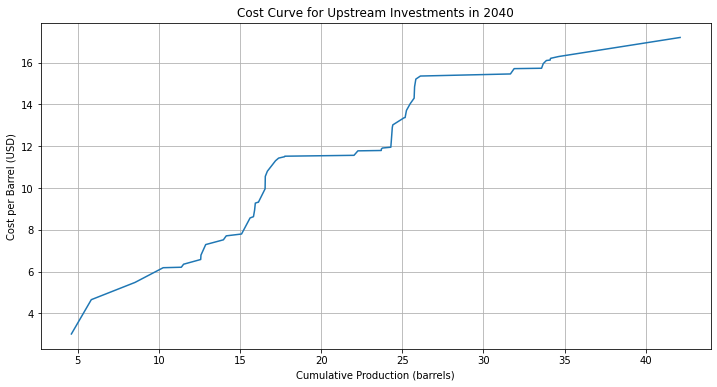

In [43]:
# Filter the combined_df for the year 2040
df_2040_production = combined_df[(combined_df['year'] == 2040) & (combined_df['country'] != 'Total')]

# Select columns 'country' and 'production'
df_2040_production = df_2040_production[['country', 'production']]

# Multiply the production by 0.365
df_2040_production['production'] *= 0.365

# Group the data by 'country' and calculate the total production in 2040
total_production_2040 = df_2040_production.groupby('country')['production'].sum().reset_index()

# Filter the country_final_investment_df for the year 2040
df_2040_investment = country_final_investment_df[country_final_investment_df['year'] == 2040]

# Select columns 'country' and 'total'
df_2040_investment = df_2040_investment[['country', 'total']]

# Merge the total production and total investment DataFrames on 'country'
merged_df = pd.merge(total_production_2040, df_2040_investment, on='country')

# Calculate the cost per barrel by dividing total investment by total production
merged_df['cost_per_barrel'] = merged_df['total'] / merged_df['production']

# Sort the DataFrame by 'cost_per_barrel' in ascending order
sorted_df = merged_df.sort_values(by='cost_per_barrel')

# Plot the cost curve
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(sorted_df['production'].cumsum(), sorted_df['cost_per_barrel'])
plt.xlabel('Cumulative Production (barrels)')
plt.ylabel('Cost per Barrel (USD)')
plt.title('Cost Curve for Upstream Investments in 2040')
plt.grid(True)
plt.show()


In [44]:
final_cost_df.head()

,country,category,2024,2025,2026,2027,2028,2029,2030,2031,...,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,C_15,capex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C_43,capex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C_24,capex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C_51,capex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C_40,capex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
import pandas as pd
import plotly.graph_objects as go

# Assuming your dataframe is named 'final_cost_df'
# We need to work with the 'dev_cost' category.
dev_cost_df = final_cost_df[final_cost_df['category'] == 'dev_cost']

# Extract columns, assuming they're integers representing years and not strings.
year_columns = [col for col in dev_cost_df.columns if isinstance(col, int)]

# If for some reason we couldn't find the year columns above, it might be because they're not integers.
# We will then try excluding known non-year columns.
if not year_columns:
    known_non_year_columns = ['country', 'category']
    year_columns = [col for col in dev_cost_df.columns if col not in known_non_year_columns]

# Calculate the minimum and maximum costs per year.
min_costs = dev_cost_df[year_columns].min()
max_costs = dev_cost_df[year_columns].max()

# Create the envelope chart.
fig = go.Figure()

# Upper boundary of the envelope.
fig.add_trace(
    go.Scatter(
        x=year_columns,
        y=max_costs,
        line=dict(color='#888888'),
        mode='lines',
        name='Max Cost',
        fill=None
    )
)

# Lower boundary and fill the area in-between.
fig.add_trace(
    go.Scatter(
        x=year_columns,
        y=min_costs,
        line=dict(color='#888888'),
        mode='lines',
        name='Min Cost',
        fill='tonexty',  # Fills the area between the 'Max Cost' and 'Min Cost'.
    )
)

# Enhance layout and design.
fig.update_layout(
    title='Development Cost Envelope 2024-2050',
    xaxis_title='Year',
    yaxis_title='Development Cost',
    showlegend=False
)

# Show the figure.
fig.show()


/var/folders/wp/nqt7cdnn0cg8jt96stsjyf100000gn/T/ipykernel_98094/2450473225.py:62: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/wp/nqt7cdnn0cg8jt96stsjyf100000gn/T/ipykernel_98094/2450473225.py:63: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

